# Homework 1 - ML for PP
Felipe Alamos

In [16]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

## Problem 1: Data Acquisition and Analysis

In [3]:
crime_2018_url = "https://data.cityofchicago.org/resource/6zsd-86xi.json?year=2018&$limit=300000"
crime_2017_url = "https://data.cityofchicago.org/resource/6zsd-86xi.json?year=2017&$limit=300000"
crime_2016_url = "https://data.cityofchicago.org/resource/6zsd-86xi.json?year=2016&$limit=300000"

def download_crime_data(year):
  url=''
  if year==2018:
    url=crime_2018_url
  elif year ==2017:
    url=crime_2017_url
  elif year ==2016:
    url=crime_2016_url
  else:
    return False
  return  pd.read_json(url)
  

df_2018 = download_crime_data(2018)
df_2017 = download_crime_data(2017)
df_2016 = download_crime_data(2016)

#Drop rows without lat, lon
df_2018=df_2018.dropna()
df_2017=df_2017.dropna()
df_2016=df_2016.dropna()

#Reset indexes
df_2018=df_2018.reset_index(drop=True)
df_2017=df_2017.reset_index(drop=True)
df_2016=df_2016.reset_index(drop=True)

                                       2017      2018    % change
Type of Crimes                                                   
TOTAL                              264178.0  262901.0   -0.483386
THEFT                               63584.0   64025.0    0.693571
BATTERY                             49136.0   49719.0    1.186503
CRIMINAL DAMAGE                     28955.0   27700.0   -4.334312
ASSAULT                             19251.0   20341.0    5.662044
DECEPTIVE PRACTICE                  16967.0   17225.0    1.520599
OTHER OFFENSE                       16965.0   16969.0    0.023578
BURGLARY                            12947.0   11686.0   -9.739708
ROBBERY                             11869.0    9680.0  -18.443003
NARCOTICS                           11475.0   12797.0   11.520697
MOTOR VEHICLE THEFT                 11367.0    9964.0  -12.342747
CRIMINAL TRESPASS                    6799.0    6881.0    1.206060
WEAPONS VIOLATION                    4682.0    5444.0   16.275096
OFFENSE IN

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 <a list of 32 Text xticklabel objects>)

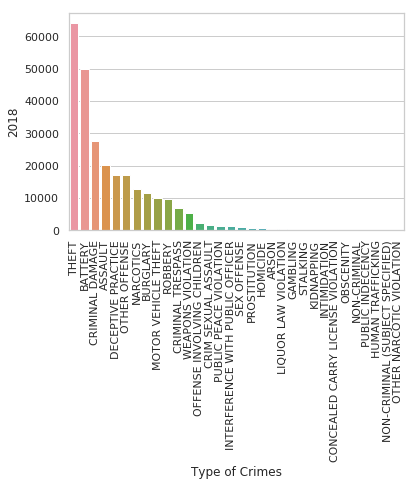

In [24]:
def load_comunities():
  comunities_url ="https://data.cityofchicago.org/resource/igwz-8jzy.json"
  return  pd.read_json(comunities_url)


# Generate summary statistics for the crime reports data including but not limited to
# number of crimes of each type, how they change over time, and how they are
# different by neighborhood. Please use a combination of tables and graphs to
# present these summary stats.


#Get frquency of different type of crimes
type_crimes_2018 = pd.DataFrame(df_2018.groupby(['primary_type']).size())
type_crimes_2018.columns = ['2018']

type_crimes_2017 = pd.DataFrame(df_2017.groupby(['primary_type']).size())
type_crimes_2017.columns = ['2017']

#Add two dataframes fill NaN with 0s
freq_table = type_crimes_2018.add(type_crimes_2017, fill_value=0)
freq_table=freq_table.fillna(0)
freq_table.index.names = ['Type of Crimes']


#Add totals
n_of_crimes_2018=df_2018.count()[0]
n_of_crimes_2017=df_2017.count()[0]
freq_table.loc['TOTAL', '2017'] = n_of_crimes_2017
freq_table.loc['TOTAL', '2018'] = n_of_crimes_2018

#Add rate change
freq_table['% change'] = freq_table['2018']/freq_table['2017']*100-100
freq_table=freq_table.sort_values('2017',ascending=False)

print(freq_table)

#Creat table for plotting, and plot
freq_table_plot = freq_table[['2017','2018']]
freq_table_plot=freq_table_plot.drop(['TOTAL'])


#Bar plot for different kind of crimes in 2018
cr_2018=type_crimes_2018.reset_index()
cr_2018=cr_2018.sort_values('2018',ascending=False)

ax = sns.barplot(x="Type of Crimes", y="2018", data=cr_2018)
plt.xticks(rotation=90)

# type_crimes_2018['Type of Crimes']
# type_crimes_2018.plot.hist()

In [25]:
#Analysis per neighborhood/community area
crime_per_neighborhood_2018 = pd.DataFrame(df_2018.groupby(['community_area']).size())
crime_per_neighborhood_2018.columns = ['# of crimes']

neighborhoods = load_comunities()
neighborhoods.index.name = 'id'

#Join between freq table per neigh and table of names of neigh
neighborhoods_table = crime_per_neighborhood_2018.join(neighborhoods, on='community_area')
neighborhoods_table = neighborhoods_table[['# of crimes','community']] #Keep only these 2 columns
neighborhoods_table.columns=['# of crimes','Neighborhood'] #Change columns names


neighborhoods_table['% of total crimes in city'] = neighborhoods_table['# of crimes']/n_of_crimes_2018*100


print(neighborhoods_table.sort_values('# of crimes',ascending=False))

#POSSIBLY HERE TO INCLUDE HEAT MAP

                # of crimes            Neighborhood  % of total crimes in city
community_area                                                                
25.0                  14922                  AUSTIN                   5.675901
8.0                   12804                WOODLAWN                   4.870274
32.0                  10639         LOWER WEST SIDE                   4.046770
29.0                   9230          NORTH LAWNDALE                   3.510827
28.0                   9227          NEAR WEST SIDE                   3.509686
43.0                   8560           MCKINLEY PARK                   3.255978
23.0                   7971           HUMBOLDT PARK                   3.031940
71.0                   7295      WASHINGTON HEIGHTS                   2.774809
24.0                   7138               WEST TOWN                   2.715090
67.0                   7027            LINCOLN PARK                   2.672869
49.0                   6835           SOUTH DEERING 

## Question 2: Data Augmentation and APIs

### 1, 2. What types of blocks have reports of “Battery”? What types of blocks get “Homicide”?

In [43]:
import geopandas as gp
from geopandas.tools import sjoin
from shapely.geometry import Point


#We will need to join the crime data with the census data
#Crime data has lat,lon information, while census data has tract number
#So, we will first make a spacial join to get a tact number for each lat,lon
#and then be able to join with census data

#Remove annoying warning
pd.options.mode.chained_assignment = None  # default='warn'

#Get shapefile, this will let as get a tract number for every lat,lon
shape_file = gp.read_file("chicago_census_tracts/census.shp")

def get_augmented_data(df):
  df=df.reset_index(drop=True)
 
  #Get point of every crime
  geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
  crs = {'init' :'epsg:4326'}
  points = gp.GeoDataFrame(crs=crs, geometry=geometry)

  #Spacial Join between the crime points and shape_file, so as to get tract
  pointInPolys = sjoin(points, shape_file, how='left',op="within")
  #Join crime data with geographic data
  df=df.join(pointInPolys, lsuffix='_caller', rsuffix='_other')
  return df

df_2018_augmented=get_augmented_data(df_2018)
df_2017_augmented=get_augmented_data(df_2017)


In [44]:
#Census info

median_income='B19013_001E,'#,NAME' #https://api.census.gov/data/2017/acs/acs5/variables.html
total_population='B01003_001E,'
white='B02001_002E,'
black='B02001_003E'

variables='NAME,'+median_income+total_population+white+black


key = '5984786462aaccc39f904bf750cc8274bd40f9f8'
url = 'https://api.census.gov/data/2017/acs/acs5?get='+variables+'&for=tract:*&in=state:17%40county:031&key='+key

#We get census data for tract
census = pd.read_json(url)
census.columns = census.iloc[0] #Move first row to header
census = census.iloc[1:] #Remove first row

#Remove tracts with negative values
census=census[pd.to_numeric(census['B19013_001E'])> 0]

#Set the index for census data to be tract, we need this for the join
census=census.set_index('tract')

def join_crime_data_with_census(crime_df):
  #Join between crime data and census based on tract
  crime_and_census = crime_df.join(census, on='tractce10')

  #Rename columns
  crime_and_census=crime_and_census.rename(columns={'B19013_001E': 'median_income', 'B01003_001E': 'total_population', 'B02001_002E':'white','B02001_003E':'african_american'})

  #Change column types to numeric
  crime_and_census["median_income"] = pd.to_numeric(crime_and_census["median_income"])
  crime_and_census["total_population"] = pd.to_numeric(crime_and_census["total_population"])
  crime_and_census["white"] = pd.to_numeric(crime_and_census["white"])
  crime_and_census["african_american"] = pd.to_numeric(crime_and_census["african_american"])

  #Group by type of crime and get mean of interesting variables
  f = {'median_income': 'mean', 'total_population': 'mean','african_american': 'mean','white': 'mean'}
  neighbors_and_census = pd.DataFrame(crime_and_census.groupby(['primary_type'], as_index=False).agg(f))
  return neighbors_and_census
  
def filter_by_crime_types(df,crimes_of_interest):

  #Filter for type of crime
  filtered_data_by_crime_type= df.loc[df['primary_type'].isin(crimes_of_interest)]
  filtered_data_by_crime_type.sort_values('median_income', ascending=True)
  filtered_data_by_crime_type['% whites']=filtered_data_by_crime_type['white']/filtered_data_by_crime_type['total_population']*100
  filtered_data_by_crime_type['% african_american']=filtered_data_by_crime_type['african_american']/filtered_data_by_crime_type['total_population']*100

  print(filtered_data_by_crime_type)

df_2018_augmented=join_crime_data_with_census(df_2018_augmented)

crimes_of_interest=['BATTERY','HOMICIDE']
filter_by_crime_types(df_2018_augmented,crimes_of_interest)


   primary_type  african_american  median_income  total_population  \
2       BATTERY       1905.591070   42992.504099       3839.574068   
10     HOMICIDE       2318.110922   34108.771331       3430.467577   

          white   % whites  % african_american  
2   1278.058291  33.286460           49.630272  
10   645.976109  18.830556           67.574197  


In the previous table we can compare the characteristics of the places where crimes related to Battery and Homicide occur. We notice, first of all, that Battery crimes occur in tract areas with higher median income that Homicide crimes (42992 vs 34108). Secondly, we notice that the white population in tracts with Battery Crimes are higher than tracts with Homicide (33% vs 18%). The opposite occurs with the black or african american population: it is proportionally higher in tracts with Homicide than Battery (67% vs 49%)

### 3. Does that change over time in the data you collected?

In [45]:
df_2017_augmented=join_crime_data_with_census(df_2017_augmented)

crimes_of_interest=['BATTERY','HOMICIDE']
filter_by_crime_types(df_2017_augmented,crimes_of_interest)

   primary_type  african_american  median_income  total_population  \
2       BATTERY       1935.842512   42494.376398       3815.688732   
10     HOMICIDE       2456.610947   34354.460059       3697.961538   

          white   % whites  % african_american  
2   1238.801024  32.465987           50.733764  
10   697.713018  18.867503           66.431490  



When looking at the data from 2017, we can observe that there are no mayor changes in the tendencies.


### 4. What is the difference in blocks that get “Deceptive Practice” vs “Sex Offense”?

In [46]:
crimes_of_interest=['DECEPTIVE PRACTICE','SEX OFFENSE']
filter_by_crime_types(df_2018_augmented,crimes_of_interest)

          primary_type  african_american  median_income  total_population  \
8   DECEPTIVE PRACTICE       1265.759872   64039.001182       4517.810948   
28         SEX OFFENSE       1392.195261   52843.732701       4114.360190   

          white   % whites  % african_american  
8   2361.130823  52.262719           28.017106  
28  1920.343128  46.674162           33.837467  


In this case, we observe higher median_income for tracts that presesent Deceptive Practice than Sex Offense. At the same time, tracts with Deceptive Practice have higher % of white population and lower of african american, compared to tracts with Sex Offense,

## Question 3
### 1. Describe how crime has changed in Chicago from 2017 to 2018?


In [47]:
freq_table.sort_values('2018',ascending=False).head(3)

,2017,2018,% change
Type of Crimes,,,
TOTAL,264178.0,262901.0,-0.483386
THEFT,63584.0,64025.0,0.693571
BATTERY,49136.0,49719.0,1.186503


Between 2017 and 2018, the total amount of crimes in the city barely changed (there was a decrease of 0.48%).

The most common type of crime in 2017 and 2018 was THEFT, followd by BATTERY.

In [48]:
freq_table.sort_values('% change',ascending=False).head(2)

,2017,2018,% change
Type of Crimes,,,
CONCEALED CARRY LICENSE VIOLATION,69.0,148.0,114.492754
HUMAN TRAFFICKING,8.0,14.0,75.000000


The type of crimes that most increased where CONCEALED CARRY LICENSE VIOLATION, from 69 in 2017 to 148 in 2018, and HUMAN TRAFFICKING (which increased in a 75%), from 8 to 14 crimes.


In [35]:
freq_table.sort_values('% change',ascending=True).head(2)

,2017,2018,% change
Type of Crimes,,,
OTHER NARCOTIC VIOLATION,11.0,1.0,-90.909091
ROBBERY,11869.0,9680.0,-18.443003


The type of crimes that most decreased was where ROBBERY (in a 18%) and OTHER NARCOTIC VIOLATION (in a 90%).

### 2. Alderman statistics

In [155]:

#Get crimes leading up to July 26, 2018
# df_2018[(df_2018['date'] == '2018-02-04')]

#Filter data for ward 43
df_2018_43 = df_2018[(df_2018['ward'] ==43)]
df_2017_43 = df_2017[(df_2017['ward'] ==43)]
df_2016_43 = df_2016[(df_2016['ward'] ==43)]

#Filter data for selected week
week_2018 = df_2018_43[(df_2018_43['date'] > '2018-07-01') & (df_2018_43['date'] < '2018-07-27')]
week_2017 = df_2017_43[(df_2017_43['date'] > '2017-07-01') & (df_2017_43['date'] < '2017-07-27')]

#Grouped by type of crime
week_2018_type_crimes = pd.DataFrame(week_2018.groupby(['primary_type']).size())
week_2017_type_crimes = pd.DataFrame(week_2017.groupby(['primary_type']).size())

#Robberies
rob_2018=week_2018_type_crimes.loc['ROBBERY'][0]
rob_2017=week_2017_type_crimes.loc['ROBBERY'][0]

#Batteries
bat_2018=week_2018_type_crimes.loc['BATTERY'][0]
bat_2017=week_2017_type_crimes.loc['BATTERY'][0]

#Burglaries
burg_2018=week_2018_type_crimes.loc['BURGLARY'][0]
burg_2017=week_2017_type_crimes.loc['BURGLARY'][0]

#Motor vehicle
mot_veh_2018=week_2018_type_crimes.loc['MOTOR VEHICLE THEFT'][0]
mot_veh_2017=week_2017_type_crimes.loc['MOTOR VEHICLE THEFT'][0]

d = {'Robberies': [rob_2017, rob_2018],
     'Batteries': [bat_2017, bat_2018],
     'Burglaries': [burg_2017, burg_2018],
     'Motor vehicle': [mot_veh_2017, mot_veh_2018]}
df = pd.DataFrame(data=d).T
df.columns = ['2017','2018']

df['2017'] = pd.to_numeric(df['2017'])
df['2018'] = pd.to_numeric(df['2018'])


df['Real % change']=(df['2018']/df['2017']-1)*100
df['Alderman announced % change']=[136,50,41,21]
df


,2017,2018,Real % change,Alderman announced % change
Batteries,38,30,-21.052632,136
Burglaries,14,13,-7.142857,50
Motor vehicle,6,10,66.666667,41
Robberies,15,8,-46.666667,21


We first observe that, for the mentioned week, the % change in the different crimes types mentioned by the alderman have no relationship with the real data. This stats are totally misleading: for batteries, burglaries and robberies, the amount of crimes has decreased, not increased as he stated. In the case of motor vehicle crimes, they have increased more than reported by Alderman.

In [141]:
percentage_raise=(week_2018.size/week_2017.size-1)*100
percentage_raise

8.766233766233755

The alderman reports that crime rose 16 percent in the same 28-day time period in just one
year, but the true crime rise was of 8.7%. This is misleading, although it does inform that crime increase for the same 28-day period, the percentage reported is almost double than real.

Lets now consider the year-to-date numbers:

In [157]:
year_to_date_2018 = df_2018_43[(df_2018_43['date'] < '2018-07-27')].size
year_to_date_2017 = df_2017_43[(df_2017_43['date'] < '2017-07-27')].size
year_to_date_2016 = df_2016_43[(df_2016_43['date'] < '2016-07-27')].size

increase_since_2017 = (year_to_date_2018/year_to_date_2017-1)*100
increase_since_2016 = (year_to_date_2018/year_to_date_2016-1)*100
print(increase_since_2017)
print(increase_since_2016)


9.72156677678151
20.155038759689916


Now the Alderman has more precise numbers. His report of an increase in 10% in the year-to-date since 2017 is accurate. Since 2016 is 20% rather than 22%, but still relatively precise.

## Question 4: 911

### A)

In [162]:
import censusgeocode as cg

#PENDING. Programatically get comunity area code
address='2111 S Michigan Ave, Chicago, IL'
e=cg.onelineaddress(address)


In [26]:
crimes_33 = df_2018.loc[df_2018['community_area'] == 33]

type_crimes_33 = pd.DataFrame(crimes_33.groupby(['primary_type']).size())
type_crimes_33.columns = ['# of crimes']
type_crimes_33.index.names = ['Type of Crimes']
type_crimes_33=type_crimes_33.sort_values('# of crimes', ascending=False)

#
total_33 = type_crimes_33['# of crimes'].sum()


type_crimes_33['Fraction of total']=type_crimes_33['# of crimes']/total_33
# freq_table.loc['TOTAL', '2017'] = n_of_crimes_2017


print(type_crimes_33)

                                   # of crimes  Fraction of total
Type of Crimes                                                   
THEFT                                      591           0.318598
BATTERY                                    289           0.155795
DECEPTIVE PRACTICE                         261           0.140701
CRIMINAL DAMAGE                            190           0.102426
ASSAULT                                    122           0.065768
OTHER OFFENSE                              111           0.059838
MOTOR VEHICLE THEFT                         71           0.038275
CRIMINAL TRESPASS                           53           0.028571
ROBBERY                                     49           0.026415
BURGLARY                                    32           0.017251
NARCOTICS                                   19           0.010243
WEAPONS VIOLATION                           12           0.006469
CRIM SEXUAL ASSAULT                         12           0.006469
PUBLIC PEA

Given the data of crimes in 2018, and the crime types in NEAR SOUTH SIDE, it is most likely that the type of crime related to the call is a Theft. The 'Fraction of total' in the previous table is a good aproximation to the probabilities of each type of request.

### B)

In [266]:
# Let’s now assume that a call comes in about Theft. Which is more likely – that the
# call came from Garfield Park or Uptown? How much more or less likely is it to be
# from Garfield Park vs Uptown?

#First filter crimes so as only to have thefts
thefts = df_2018.loc[df_2018['primary_type'] == 'THEFT']

#Group by community_areas
thefts = pd.DataFrame(thefts.groupby(['community_area']).size())
thefts.columns = ['# of thefts']


#Join with neighborhoods info to get names of community_areas
thefts_neighborhoods = thefts.join(neighborhoods, on='community_area')
thefts_neighborhoods = thefts_neighborhoods[['# of thefts','community']] #Keep only these 2 columns
thefts_neighborhoods.columns=['# of thefts','Neighborhood'] #Change columns names

#Filter neighborhoods
some_neighbors=['WEST GARFIELD PARK','EAST GARFIELD PARK','UPTOWN']
crimes_uptown_or_garfield=thefts_neighborhoods.loc[thefts_neighborhoods['Neighborhood'].isin(some_neighbors)]
crimes_uptown_or_garfield = crimes_uptown_or_garfield.reset_index()

#Drop community_area code column
crimes_uptown_or_garfield = crimes_uptown_or_garfield.drop(['community_area'], axis=1)

total_garfield = crimes_uptown_or_garfield.loc[0]['# of thefts'] + crimes_uptown_or_garfield.loc[1]['# of thefts']

#Create new row with total for Garfield
crimes_uptown_or_garfield = crimes_uptown_or_garfield.append({'# of thefts' : total_garfield , 'Neighborhood' : 'GARFIELD'} , ignore_index=True)


#Delete previous garfield rows
final_neighbors=['GARFIELD','UPTOWN']
crimes_uptown_or_garfield=crimes_uptown_or_garfield.loc[crimes_uptown_or_garfield['Neighborhood'].isin(final_neighbors)]

# crimes_uptown_or_garfield = crimes_uptown_or_garfield[['Neighborhood', '# of thefts']]
print(crimes_uptown_or_garfield)


   # of thefts Neighborhood
2          795       UPTOWN
3         1333     GARFIELD


Considering the amounts of thefts that occured in 2019, we can observe that it is more likely that a new theft will occur in Garfield rather than in Uptown. The following number representes how much more likely is it the theft to be from Garfield Park vs Uptown:

In [267]:
change_likelihood=crimes_uptown_or_garfield.iloc[1]['# of thefts']/crimes_uptown_or_garfield.iloc[0]['# of thefts']-1
print(str(change_likelihood*100)+'%')


67.67295597484278%


### C)

In [22]:



garfield_battery_calls=100
uptown_battery_calls=160
total_battery_calls=garfield_battery_calls+uptown_battery_calls

prob_bat_call_from_garf = garfield_battery_calls/total_battery_calls
prob_bat_call_from_uptown = uptown_battery_calls/total_battery_calls

print(prob_bat_call_from_garf)
print(prob_bat_call_from_uptown)
print(prob_bat_call_from_uptown/prob_bat_call_from_garf)




0.38461538461538464
0.6153846153846154
1.6


If the call is know to be a Battery, then the probability that it is from Garfield is 0.38, while the probability for Uptown is 0.62. So, it is ~60% more likely that the probabiliry is from Uptown than Garfield.
